In [1]:
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import data_util
import models
import torch
import loss
import train
import pandas as pd
import numpy as np

In [255]:
device = "cuda" if torch.cuda.is_available() else "cpu"

training_fraction = 0.8
batch_size = 160
proportional = True

is_gdro = True

hparams = {"groupdro_eta": 0.03}

In [311]:
# code to get max slice data from the all slices set

# all_slices = pd.read_csv('data/LIDC_20130817_AllFeatures2D_AllSlices_MattEdited.csv')
# max_slices = []

# nodule_radiologist_pairings = set(zip(all_slices["RadiologistID"], all_slices["noduleID"]))

# for radiologist_id, nodule_id in nodule_radiologist_pairings:
#     nodule_data = all_slices.loc[(all_slices["RadiologistID"] == radiologist_id) & (all_slices["noduleID"] == nodule_id), :]
    
#     max_slice = nodule_data.iloc[np.argmax(nodule_data["Area"]), :]
#     max_slices.append(max_slice)

# max_slice_df = pd.DataFrame(max_slices).sort_values(["noduleID", "RadiologistID"], axis=0).reset_index().drop(columns="index")
# max_slice_df

In [321]:
df = data_util.preprocess_data(*data_util.load_data())

In [322]:
sum(df["Malignancy"] == 0) / len(df)

0.6133525456292027

In [323]:
# get train/test flags
train_test = pd.read_csv("data/lidc_train_test_radiologist.csv")

# create train/test dataframes
training_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "train"]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "test"]["noduleID"].values)]

# use noduleIDs as index, it makes things easier
subtype_df.index = subtype_df["noduleID"].values


# Test convergence of combinations of ERM and GDRO

In [341]:
N = 30
epochs = 40
subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Adaptive", "ExtraERM", "ExtraGDRO", "Halfway"]
# test_algorithms = ["Mix" + str(t) for t in [0.4, 0.5, 0.6, 0.7, 0.8]]
test_algorithms = ["ERM", "GDRO", "Halfway"]

results = {algorithm: np.zeros(N * epochs * len(subtypes)) for algorithm in test_algorithms}
for algorithm in test_algorithms:

    print("Running test: " + algorithm)

    # create the training and testing dataloaders
#     if algorithm == "ERM":
#         train_dataloader = data_util.create_dataloader(training_df, batch_size)
#     else:
#         train_dataloader = data_util.create_subtyped_dataloader(training_df, subtype_df, batch_size, proportional)
#     test_dataloader = data_util.create_subtyped_dataloader(test_df, subtype_df, batch_size, proportional)
    
    train_dataloader = data_util.create_dataloader(training_df, batch_size)
    test_dataloader = data_util.create_dataloader(test_df, batch_size)

    for n in range(N):

        print(f"Trial {n + 1}/{N}")

        # create and train model
        model = models.NeuralNetwork(64, 32, 32, 2)
        model.to(device)

        if (algorithm == "ERM"):
            loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), hparams, subclassed=True)
        elif (algorithm == "GDRO"):
            loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["groupdro_eta"], 4, normalize_loss=True)
        else:
            loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, 4, normalize_loss=True, subclassed=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

        for epoch in range(epochs):
            if algorithm == "Sharp":
                loss_fn.t = epoch / epochs < 0.5  # sharp boundary
            elif algorithm == "Smooth":
                loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
            elif algorithm == "ReverseSmooth":
                loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
            elif algorithm == "Adaptive":
                acc = train.test(test_dataloader, model)[0]
                loss_fn.t = acc < 0.85  # use gdro when overall accuracy is above threshold
            elif algorithm == "ExtraERM":
                loss_fn.t = 2
            elif algorithm == "ExtraGDRO":
                loss_fn.t = -1
            elif algorithm == "Halfway":
                loss_fn.t = 0.5
            elif algorithm.startswith("Mix"):
                loss_fn.t = float(algorithm[3:])  # ex. algorithm == "Mix0.5" => t = 0.5

            train.train(train_dataloader, model, loss_fn, optimizer)
            sensitivities = train.test(test_dataloader, model)

            for i in range(len(subtypes)):
                results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

print("Test complete")

Running test: ERM
Trial 1/30
Trial 2/30
Trial 3/30
Trial 4/30
Trial 5/30
Trial 6/30
Trial 7/30
Trial 8/30
Trial 9/30
Trial 10/30
Trial 11/30
Trial 12/30
Trial 13/30
Trial 14/30
Trial 15/30
Trial 16/30
Trial 17/30
Trial 18/30
Trial 19/30
Trial 20/30
Trial 21/30
Trial 22/30
Trial 23/30
Trial 24/30
Trial 25/30
Trial 26/30
Trial 27/30
Trial 28/30
Trial 29/30
Trial 30/30
Running test: GDRO
Trial 1/30
Trial 2/30
Trial 3/30
Trial 4/30
Trial 5/30
Trial 6/30
Trial 7/30
Trial 8/30
Trial 9/30
Trial 10/30
Trial 11/30
Trial 12/30
Trial 13/30
Trial 14/30
Trial 15/30
Trial 16/30
Trial 17/30
Trial 18/30
Trial 19/30
Trial 20/30
Trial 21/30
Trial 22/30
Trial 23/30
Trial 24/30
Trial 25/30
Trial 26/30
Trial 27/30
Trial 28/30
Trial 29/30
Trial 30/30
Running test: Halfway
Trial 1/30
Trial 2/30
Trial 3/30
Trial 4/30
Trial 5/30
Trial 6/30
Trial 7/30
Trial 8/30
Trial 9/30
Trial 10/30
Trial 11/30
Trial 12/30
Trial 13/30
Trial 14/30
Trial 15/30
Trial 16/30
Trial 17/30
Trial 18/30
Trial 19/30
Trial 20/30
Trial 21

In [342]:
trial_means = results_df.unstack().unstack().median().unstack(level=0).unstack(level=1).stack()
trial_means

ERM      GDRO   Halfway
subtype                epoch                              
Overall                0      0.786875  0.772500  0.776250
                       1      0.789375  0.782500  0.785000
                       2      0.800000  0.795000  0.800000
                       3      0.808750  0.806250  0.805625
                       4      0.813750  0.802500  0.806875
...                                ...       ...       ...
Unspiculated malignant 35     0.874825  0.872283  0.884931
                       36     0.862407  0.848340  0.887841
                       37     0.866667  0.880476  0.850996
                       38     0.865537  0.856373  0.889286
                       39     0.866667  0.852273  0.886305

[200 rows x 3 columns]

In [343]:
worst_group = trial_means.unstack(level=1).min().unstack(level=0)
worst_group.index = pd.MultiIndex.from_product([["Worst"], worst_group.index], names=["subtype", "epoch"])
worst_concat = pd.concat([trial_means.unstack(level=1).stack(), worst_group])
worst_concat

ERM      GDRO   Halfway
subtype epoch                              
Overall 0      0.786875  0.772500  0.776250
        1      0.789375  0.782500  0.785000
        2      0.800000  0.795000  0.800000
        3      0.808750  0.806250  0.805625
        4      0.813750  0.802500  0.806875
...                 ...       ...       ...
Worst   35     0.742396  0.742210  0.733010
        36     0.751344  0.758306  0.739421
        37     0.739906  0.747350  0.738235
        38     0.745960  0.747116  0.739570
        39     0.727669  0.743238  0.746379

[240 rows x 3 columns]

In [344]:
"""
Test parameters

input: 64 engineered features extracted from lidc max-slice images

model layer sizes = (64, 32, 32, 2)
groupdro_eta = 0.1
lr = 0.001
weight_decay = 0.005

batch_size = 40
proportional = True
epochs = 40
N = 120

"""

'\nTest parameters\n\ninput: 64 engineered features extracted from lidc max-slice images\n\nmodel layer sizes = (64, 32, 32, 2)\ngroupdro_eta = 0.1\nlr = 0.001\nweight_decay = 0.005\n\nbatch_size = 40\nproportional = True\nepochs = 40\nN = 120\n\n'

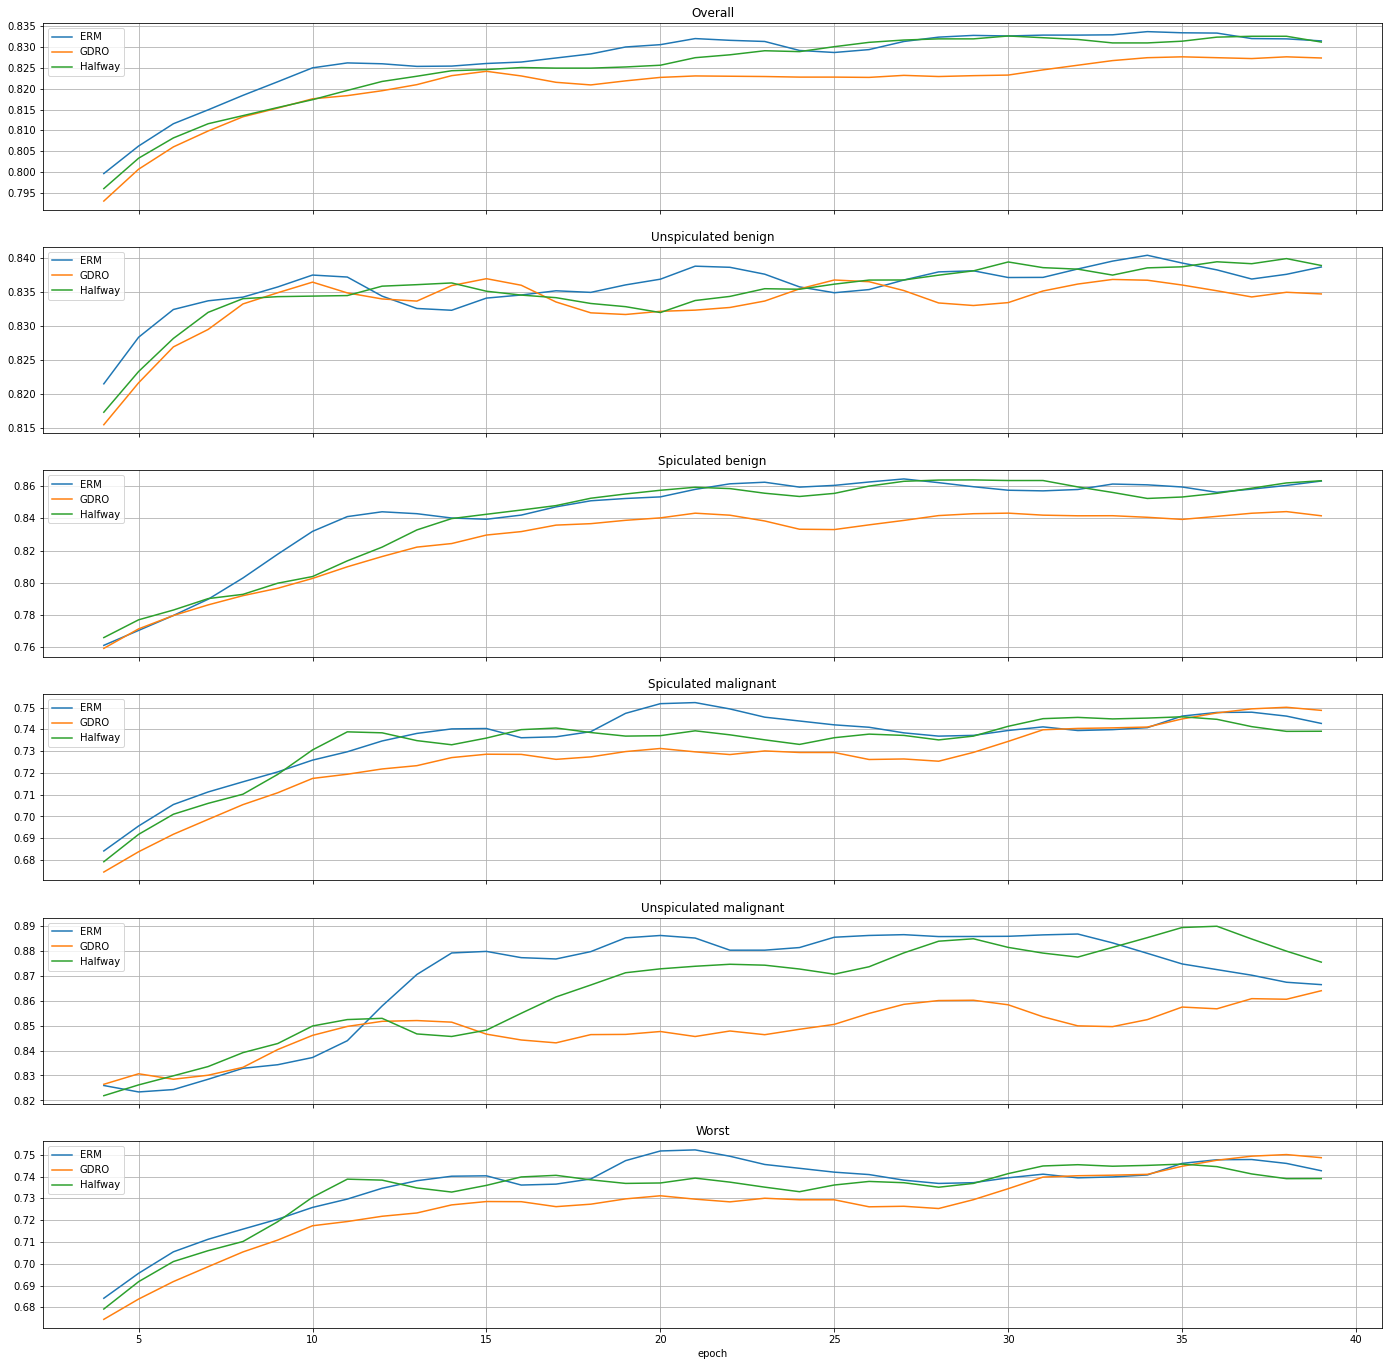

In [345]:
import matplotlib.pyplot as plt

rolling_window = 3

rolling_data = worst_concat.unstack(level=0).rolling(rolling_window).mean().unstack().unstack(level=0)

plots = [*subtypes, "Worst"]

hide = []

f, a = plt.subplots(len(plots),1, sharex = True)
# plot subtypes sensitivity
for i in range(len(plots)):
    rolling_data.drop(columns=hide).rolling(rolling_window).mean().xs(plots[i]).plot(kind='line',title=plots[i],ax=a[i],figsize=(24,24),grid=True)

In [215]:
# data for test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Adaptive", "ExtraERM", "ExtraGDRO", "Halfway"]
# N = 50, epochs = 20
all_data

ERM      GDRO     Sharp    Smooth  ReverseSmooth  \
subtype epoch                                                          
Overall 0      0.791175  0.794600  0.796000  0.795200       0.799350   
        1      0.813800  0.802875  0.818700  0.815475       0.805350   
        2      0.821025  0.814075  0.819425  0.817875       0.817375   
        3      0.821625  0.812075  0.822275  0.820175       0.829325   
        4      0.829825  0.819725  0.826100  0.824600       0.830925   
...                 ...       ...       ...       ...            ...   
Worst   15     0.675100  0.732846  0.753460  0.735389       0.713223   
        16     0.685194  0.722461  0.735347  0.726454       0.707076   
        17     0.678407  0.738425  0.731847  0.709797       0.706589   
        18     0.682105  0.736175  0.737202  0.697710       0.684052   
        19     0.684803  0.733521  0.712378  0.689144       0.685421   

               Adaptive  ExtraERM  ExtraGDRO   Halfway  
subtype epoch                                           
Overall 0      0.797875  0.796725   0.211975  0.793275  
        1      0.810950  0.814675   0.202700  0.812650  
        2      0.818325  0.822250   0.226925  0.824725  
        3      0.823125  0.825225   0.205675  0.826900  
        4      0.825750  0.831075   0.210875  0.831625  
...                 ...       ...        ...       ...  
Worst   15     0.706351  0.750009   0.354582  0.749469  
        16     0.717552  0.749584   0.240623  0.758230  
        17     0.720562  0.746536   0.155855  0.760911  
        18     0.697140  0.751371   0.140000  0.759874  
        19     0.710979  0.759447   0.100000  0.748907  

[120 rows x 9 columns]

In [ ]:
# old results with flawed malignancy labels + CNN subtypes
data_clean0